In [7]:
"""
    (Successful) Attempt for the controlled version:
"""
import numpy as np
import qiskit
from qiskit.quantum_info import state_fidelity
from numpy import linalg as LA
import qib
import matplotlib.pyplot as plt
import scipy
import h5py

import rqcopt as oc
from scipy.sparse.linalg import expm_multiply
from qiskit.quantum_info import random_statevector

Lx, Ly = (2, 2)
L = Lx*Ly
t = .125
latt = qib.lattice.IntegerLattice((Lx, Ly), pbc=True)
field = qib.field.Field(qib.field.ParticleType.QUBIT, latt)
J, h, g = (1, 0, 3)
hamil = qib.IsingHamiltonian(field, J, h, g).as_matrix()
eigenvalues, eigenvectors = scipy.sparse.linalg.eigsh(hamil, k=10)
idx = eigenvalues.argsort()
eigenvalues_sort = eigenvalues[idx]
eigenvectors_sort = eigenvectors[:,idx]
ground_state = eigenvectors_sort[:, 0]

"""X = np.array([[0, 1], [1, 0]])
Z = np.array([[1, 0], [0, -1]])
Y = np.array([[0, -1j], [1j, 0]])
I2 = np.array([[1, 0], [0, 1]])

hloc1 = construct_ising_local_term(J/2, 0, 0, ndim=2)
hloc2 = g*(np.kron(X, I2)+np.kron(I2, X))/2

V1 = scipy.linalg.expm(-1j*t*hloc1/4)
V2 = scipy.linalg.expm(-1j*t*hloc2/2)
V3 = scipy.linalg.expm(-1j*t*hloc1/2)
V4 = scipy.linalg.expm(-1j*t*hloc2)
YZ = np.kron(Y, Z)

Vlist_start = [YZ, V3, V4, V3, YZ] * 2"""

#perms_v, perms_h = get_perms(Lx, Ly)
perms_v, perms_h = ([[0, 2, 1, 3]], [[0, 1, 2, 3]])

perms_extended = [[perms_v[0]]] + [perms_v]*3 + [[perms_v[0]], [perms_h[0]]] +\
                    [perms_h]*3 + [[perms_h[0]]]
perms_ext_reduced = [perms_v]*3  + [perms_h]*3
control_layers = [0, 4, 5, 9]           # 4 control layers

Current error:  0.131193013872221
Current error:  0.11616352619034627
Current error:  0.08692108858477969
Current error:  0.03678871205496406
Current error:  0.007569859552747107
Current error:  0.006430783022150495
Current error:  0.006348497494505566
Current error:  0.006348497494505566
Current error:  0.006342775654446412
Current error:  0.0063424974428659305
Current error:  0.006342335555487035
0.006342335555487035


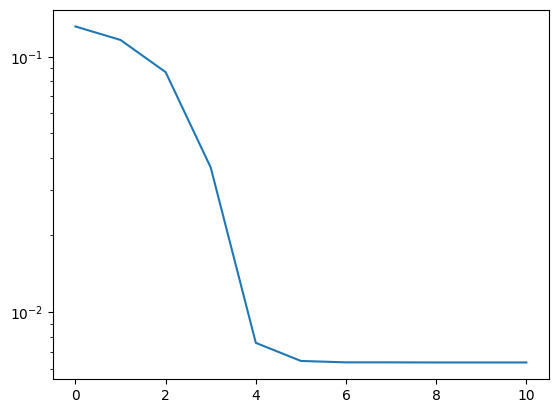

In [83]:
from optimize_sparse import optimize, err

Vlist, f_iter, err_iter = optimize(L, hamil, t, Vlist_start, perms_extended, perms_reduced=perms_ext_reduced, 
                                   control_layers=control_layers, rS=3, niter=10)
plt.plot(err_iter)
plt.yscale('log')
print(err_iter[-1])

In [64]:
with h5py.File(f"./results/tfim2d_ccU_SPARSE_{J}{h}{g}_Lx{Lx}Ly{Ly}_t{t}_layers{len(Vlist_start)}_niter10_rS1_2hloc.hdf5", "w") as f:
    f.create_dataset("Vlist", data=Vlist)
    f.create_dataset("f_iter", data=f_iter)
    f.create_dataset("err_iter", data=err_iter)
    f.attrs["L"] = L
    f.attrs["t"] = float(t)

In [2]:
#with h5py.File(f"./tfim2d_ccU_SPARSE_{J}{h}{g}_Lx{Lx}Ly{Ly}_t{t}_layers{len(Vlist_start)}_niter7_rS1_2hloc.hdf5", "r") as f:
#    Vlist =  f["Vlist"][:]

#with h5py.File(f"./results/tfim2d_ccU_SPARSE_103_Lx4Ly4_t{t}_layers15_rS1_niter15_3hloc.hdf5", "r") as f:
#    Vlist =  f["Vlist"][:]

#with h5py.File(f"./results/tfim2d_ccU_SPARSE_103_Lx4Ly4_t0.5_layers15_rS1_niter30_3hloc.hdf5", "r") as f:
#    Vlist =  f["Vlist"][:]

#with h5py.File(f"./results/tfim2d_ccU_SPARSE_103_Lx4Ly4_t0.25_layers15_rS5_niter20_3hloc.hdf5", "r") as f:
#    Vlist =  f["Vlist"][:]

#with h5py.File(f"./results/tfim2d_ccU_SPARSE_103_Lx4Ly4_t1_layers15_rS1_niter25_3hloc.hdf5", "r") as f:
#    Vlist =  f["Vlist"][:]

# -------------
#with h5py.File(f"./results/tfim2d_ccU_SPARSE_103_Lx4Ly4_t0.25_layers10_niter5_rS1_2hloc.hdf5", "r") as f:
#    Vlist =  f["Vlist"][:]
with h5py.File(f"./results/tfim2d_ccU_SPARSE_103_Lx2Ly2_t{t}_layers10_niter10_rS1_2hloc.hdf5", "r") as f:
    Vlist =  f["Vlist"][:]

perms_extended = [[perms_v[0]]] + [perms_v]*3 + [[perms_v[0]], [perms_h[0]]] +\
                    [perms_h]*3 + [[perms_h[0]]]
perms_ext_reduced = [perms_v]*3  + [perms_h]*3
control_layers = [0, 4, 5, 9] 			# 4 control layers

In [3]:
"""
    Test operations.
"""
import sys
sys.path.append("../../src/brickwall_sparse")
from utils_sparse import construct_ising_local_term, reduce_list, X, I2, get_perms
from ansatz_sparse import ansatz_sparse

Vlist_reduced = []
for i, V in enumerate(Vlist):
    if i not in control_layers:
        Vlist_reduced.append(V)

state = random_statevector(2**L).data
print("Trotter error of the optimized point: ", (np.linalg.norm(ansatz_sparse(Vlist, L, perms_extended, state) - expm_multiply(
    1j * t * hamil, state), ord=2) + np.linalg.norm(ansatz_sparse(Vlist_reduced, L, perms_ext_reduced, state) - expm_multiply(
    -1j * t * hamil, state), ord=2))/2)

print('infidelity: ', 1-(state_fidelity(ansatz_sparse(Vlist, L, perms_extended, state), expm_multiply(
    1j * t * hamil, state)) + state_fidelity(ansatz_sparse(Vlist_reduced, L, perms_ext_reduced, state), expm_multiply(
    -1j * t * hamil, state)))/2)

Trotter error of the optimized point:  0.030882090611582452
infidelity:  0.0010903106457095246


In [85]:
sys.path.append("../../src/controlled_unitary_optimizer")
sys.path.append("../../src/brickwall_ansatz")
from optimize_3q import optimize_3q 
from utils_3q import make_controlled, random_unitary

Xlists_opt = {}
#perms_qc = [[0, 1], [0, 2], [1, 2], [0, 2], [0, 1], [1, 2], [0, 2], [0, 1], [1, 2]]
perms_qc = [[0, 1], [0, 2]]

for i in control_layers:
    cU = make_controlled(Vlist[i])
    f_best, err_best, Glist_best = (0, 2, None)
    for _ in range(10):
        Xlist_start = [random_unitary(4) for i in range(len(perms_qc))]
        Xlist, f_iter, err_iter = optimize_3q(L, cU, Xlist_start, perms_qc, niter=1000)
        if err_iter[-1] < err_best:
            f_best, err_best, Xlist_best = (f_iter[-1], err_iter[-1], Xlist)
    print("Best f: ", f_best)
    print("Best err: ", err_best)
    Xlists_opt[i] = Xlist_best

/opt/anaconda3/envs/qc/lib/python3.10/site-packages/rqcopt/trust_region.py:81: RuntimeWarning: divide by zero encountered in scalar divide
  alpha = rsq / dHd
/opt/anaconda3/envs/qc/lib/python3.10/site-packages/rqcopt/trust_region.py:40: RuntimeWarning: divide by zero encountered in scalar divide
  rho = (f(x_next) - fx) / (np.dot(grad, eta) + 0.5 * np.dot(eta, hess @ eta))
/opt/anaconda3/envs/qc/lib/python3.10/site-packages/rqcopt/trust_region.py:40: RuntimeWarning: invalid value encountered in scalar divide
  rho = (f(x_next) - fx) / (np.dot(grad, eta) + 0.5 * np.dot(eta, hess @ eta))


Best f:  -7.999134153670267
Best err:  0.03266678980096438
Best f:  -7.999033691442941
Best err:  0.03385994198444227
Best f:  -7.9992347585959696
Best err:  0.02948342361909008
Best f:  -7.999373098935177
Best err:  0.02587279164837814


In [68]:
# Save the optimal gates.

perms_qc = [[0, 1], [0, 2]]
for i in control_layers:
    with h5py.File(f"./results/tfim2d_ccU_SPARSE_{J}{h}{g}_Lx{Lx}Ly{Ly}_t{t}_layers{len(Vlist)}_niter15_rS1_DECOMPOSE_n{len(perms_qc)}_layer{i}.hdf5", "w") as file:
        file.create_dataset(f"Xlist_{i}", data=Xlists_opt[i])

In [4]:
#Xlists_opt = {}
#for i in control_layers:
#    with h5py.File(f"./results/tfim2d_ccU_SPARSE_{J}{h}{g}_Lx{Lx}Ly{Ly}_t{t}_layers{len(Vlist)}_niter30_rS1_DECOMPOSE_n{len(perms_qc)}_layer{i}.hdf5", "r") as file:
#        Xlists_opt[i] = file[f"Xlist_{i}"][:]

"""perms_qc = [[0, 1], [0, 2], [1, 2], [0, 2], [0, 1], [1, 2]]
Xlists_opt = {}
for i in control_layers:
    with h5py.File(f"./results/tfim2d_ccU_SPARSE_{J}{h}{g}_Lx{Lx}Ly{Ly}_t{t}_layers{len(Vlist)}_niter20_rS5_DECOMPOSE_n{len(perms_qc)}_layer{i}.hdf5", "r") as file:
        Xlists_opt[i] = file[f"Xlist_{i}"][:]"""

perms_qc = [[0, 1], [0, 2]]
Xlists_opt = {}
for i in control_layers:
    with h5py.File(f"./results/tfim2d_ccU_SPARSE_{J}{h}{g}_Lx{Lx}Ly{Ly}_t{t}_layers{len(Vlist)}_niter15_rS1_DECOMPOSE_n{len(perms_qc)}_layer{i}.hdf5", "r") as file:
        Xlists_opt[i] = file[f"Xlist_{i}"][:]


In [9]:
from qiskit import Aer, execute, transpile
from qiskit.circuit.library import CYGate, CZGate, IGate, CXGate
from qiskit.converters import circuit_to_dag
from qiskit.providers.aer.noise import NoiseModel, errors
from qiskit import Aer, execute, transpile
from scipy import sparse as sp


qc = qiskit.QuantumCircuit(L+1)
qc.x(L)
for i, V in enumerate(Vlist):
    layer = i
    if i in control_layers:
        Glist = Xlists_opt[i]
        qc_3 = qiskit.QuantumCircuit(3)
        for j, G in enumerate(Glist):
            qc_3.unitary( G, (3-1-perms_qc[j][1], 3-1-perms_qc[j][0]))

        for perm in perms_extended[layer]:
            for j in range(L//2):
                qc.append(qc_3.to_gate(), [L-perm[2*j]-1, L-perm[2*j+1]-1, L])
        
    else:
        for perm in perms_extended[layer]:
            for j in range(L//2):
                qc.unitary(V, [L-perm[2*j]-1, L-perm[2*j+1]-1])
qc.x(L)


#ccU_cxs_05= []
#ccU_errs_05 = []
for t_ in [t*2]:
    state = random_statevector(2**L).data
    qc_ext1 = qiskit.QuantumCircuit(L+1)
    qc_ext1.initialize(state, [i for i in range(L)])
    for i in range(int(t_/t)):
        qc_ext1.append(qc.to_gate(), [i for i in range(L+1)])

    backend = Aer.get_backend("statevector_simulator")
    sv1 = execute(transpile(qc_ext1), backend).result().get_statevector().data

    qc_ext2 = qiskit.QuantumCircuit(L+1)
    qc_ext2.initialize(state, [i for i in range(L)])
    qc_ext2.x(L)
    for i in range(int(t_/t)):
        qc_ext2.append(qc.to_gate(), [i for i in range(L+1)])
    backend = Aer.get_backend("statevector_simulator")
    sv2 = execute(transpile(qc_ext2), backend).result().get_statevector().data

    ket_0 = np.array([1, 0])
    ket_1 = np.array([0, 1])
    exact_v1 = np.kron(ket_0, expm_multiply(1j * t_ * hamil, state))
    exact_v2 = np.kron(ket_1, expm_multiply(-1j * t_ * hamil, state))
    #err = (np.linalg.norm(sv1-exact_v1, ord=2) + np.linalg.norm(sv2-exact_v2, ord=2))/2
    err = (1-state_fidelity(sv1, exact_v1) + 1-state_fidelity(sv2, exact_v2))/2
    
    noise_model = NoiseModel()
    dag = circuit_to_dag(transpile(qc_ext1, basis_gates=noise_model.basis_gates+['unitary', 'initialize', 'cx']))
    count_ops = dag.count_ops_longest_path()
    print(count_ops)
    
    #ccU_errs_05.append(err)
    #ccU_cxs_05.append(count_ops['unitary'])
    print(f"t={t}, Gate Count: ", count_ops['unitary'], " State infidelity: ", err)
    #print("Fidelity: ", 1-err)

{'sx': 4, 'unitary': 36}
t=0.125, Gate Count:  36  State infidelity:  0.0051785261864463195


In [10]:
"""

    Exact Initialization + Iterative QPE
    Let's assume we can efficiently encode a DMRG ground state.

"""
import sys
sys.path.append("../../src/qpe")
from qpe import estimate_phases

def norm_mod2pi(theta):
    return np.pi - np.abs((theta%(2*np.pi)) - np.pi) 

def run_QPE(qc_prepared_state, qc_cU, basis_time, init_guess, Ns, final_digit, depolarizing_error, custom_phase=None, 
            hide_print=False, init_digit=-1, T=None):
    theta_prev = -init_guess
    est_prev = init_guess

    x1_error = errors.depolarizing_error(depolarizing_error*0.01, 1)
    x2_error = errors.depolarizing_error(depolarizing_error, 2)
    noise_model = NoiseModel()
    noise_model.add_all_qubit_quantum_error(x1_error, ['u1', 'u2', 'u3'])
    noise_model.add_all_qubit_quantum_error(x2_error, ['cu3', 'cx', 'str', 'cy', 'cz', 'unitary'])
    
    Es = []
    ests_ = []
    thetas_ = []
    cxss_A = []
    mid_cbits = 0
    mid_errs_A = []
    for j in list(range(init_digit, final_digit+1, 1)):
        if T:
            T = T * 2
        else:
            T = 2**j

        if custom_phase is None:
            theta_prev_ = theta_prev
            counts_real, counts_imag, cxs = estimate_phases(
                                                    L, qc_C, eigenvalues_sort, T/2, basis_time,
                                                    Ns, depolarizing_error, qc_cU, noise_model=noise_model,
                                                    return_counts=True,
                                                    get_cx=True, qasm=False
                                               )[0]
            #cxss_A.append(cxs['unitary'])
            #print('CXs: ', cxss_A[-1])
            print(cxs)
        
            phase_est_real = ((counts_real['0'] if '0' in counts_real else 0) - (counts_real['1'] if '1' in counts_real else 0)) /\
                        ((counts_real['0'] if '0' in counts_real else 0) + (counts_real['1'] if '1' in counts_real else 0))     
            phase_est_imag = ((counts_imag['0'] if '0' in counts_imag else 0) - (counts_imag['1'] if '1' in counts_imag else 0)) /\
                        ((counts_imag['0'] if '0' in counts_imag else 0) + (counts_imag['1'] if '1' in counts_imag else 0))
            phase = phase_est_real + 1j*phase_est_imag
        else:
            T, phase = custom_phase

        if not hide_print:
            print("Exact Phase: ", np.exp(-1j * T * eigenvalues_sort[0]))
            print("Estimated Phase: ", phase)
            print("Estimated Phase Amplitude: ", np.linalg.norm(phase))
                
        if phase.real != 0:
            angle = np.arctan(phase.imag/phase.real) if phase.real>0 else (np.pi + np.arctan(phase.imag/phase.real) if phase.imag>0 else \
                                                                               np.arctan(phase.imag/phase.real) - np.pi)
        else:
            angle = np.pi/2 if phase.imag > 0 else -np.pi/2

    
        if T>1:
            thetas = [(angle + k*2*np.pi)/T for k in range(T+1)]
            norms = np.array([norm_mod2pi(theta - theta_prev) for theta in thetas])
            id_ = np.argmin(norms)
                    
            ests = [-thetas[id_] - coe*np.pi for coe in range(2, 40, 2)]
            est = ests[0]
            for est_ in ests[1:]:
                est = est_ if np.abs(est_-est_prev) < np.abs(est-est_prev) else est
            ests_.append(est)
            thetas_.append(thetas[id_])
            theta_prev = thetas_[-1]
        else:
            thetas = [(angle + k*np.pi)/T for k in range(0, 40, 2)]
            ests = [-theta for theta in thetas]
            est = ests[0]
            for est_ in ests[1:]:
                est = est_ if np.abs(est_-est_prev) < np.abs(est-est_prev) else est
            ests_.append(est)
            thetas_.append(-est)
            theta_prev = thetas_[-1]
    
        est_prev = ests_[-1]
        if not hide_print:
            print("Final Estimation Result, Abs Error: ", np.abs(est_prev-eigenvalues_sort[0]))    
            print("Final Estimation Result, Relative Error: ", np.abs(est_prev-eigenvalues_sort[0])/np.abs(eigenvalues_sort[0]), '\n')    
        mid_errs_A.append(np.abs(est_prev-eigenvalues_sort[0]))
        Es.append(est_prev)
    return Es

In [4]:
"""
    Adiabatic Evolution Implementation.
"""
from qiskit import Aer, transpile, execute

def trotter(Lx, Ly, tau, L, J_i, h_i, g_i, J_f, h_f, g_f, lamb):
    L = Lx * Ly
    assert lamb <= 1 and lamb >= 0
    J = lamb*J_f + (1-lamb)*J_i
    g = lamb*g_f + (1-lamb)*g_i
    h = lamb*h_f + (1-lamb)*h_i

    qc = qiskit.QuantumCircuit(L)
    hloc = construct_ising_local_term_(J, g, 2)
        
    # permutations specifying gate layout
    # Verticals
    perms_vercs = []
    for i in range(Ly):
        start_ind = Lx*i
        perms_verc = []
        for j in range(start_ind, start_ind+Lx):
            perms_verc += [j, (j+Lx)%L]
        perms_vercs.append(perms_verc)
    if Ly == 4:
        perms_vercs = [perms_vercs[0]+perms_vercs[2], perms_vercs[1]+perms_vercs[3]]
    # Horizontals
    perms_horzs = []
    for i in range(Lx):
        start_ind = i
        perms_horz = []
        for j in range(start_ind, L, Lx):
            if start_ind != Lx-1:
                perms_horz += [j, j+1]
            else:
                perms_horz += [j, j+1-Lx]
        perms_horzs.append(perms_horz)
    if Lx == 4:
        perms_horzs = [perms_horzs[0]+perms_horzs[2], perms_horzs[1]+perms_horzs[3]]
    perm_set = perms_vercs + perms_horzs
    perms = perm_set
    
    method_start = oc.SplittingMethod.suzuki(len(perm_set), 1)
    indices = method_start.indices
    coeffs = method_start.coeffs

    Vlist_start = []
    perms = []
    for i, c in zip(indices, coeffs):
        Vlist_start.append(scipy.linalg.expm(-1j*c*tau*hloc))
        perms.append(perm_set[i])
    Vlist_gates = []
    for V in Vlist_start:
        qc2 = qiskit.QuantumCircuit(2)
        qc2.unitary(V, [0, 1])
        Vlist_gates.append(qc2)
    
    for layer, qc_gate in enumerate(Vlist_gates):     
        for j in range(len(perms[layer])//2):
            qc.append(qc_gate.to_gate(), [L-(perms[layer][2*j]+1), L-(perms[layer][2*j+1]+1)])
    return qc


def construct_ising_local_term_(J, g, ndim, h=0):
    X = np.array([[0.,  1.], [1.,  0.]])
    Z = np.array([[1.,  0.], [0., -1.]])
    I = np.identity(2)
    return J*np.kron(Z, Z) + g*(0.5/ndim)*(np.kron(X, I) + np.kron(I, X)) + h*(0.5/ndim)*(np.kron(Z, I) + np.kron(I, Z))


def run_adiabatic(Lx, Ly, g, T, S, state, return_state=False, h_i=0, h_f=0):
    L = Lx*Ly
    tau = 1/S
    t_s = np.linspace(0, T, S*T)
    sch = lambda t, T: np.sin(np.pi*t/(2*T))**2
    
    qc = qiskit.QuantumCircuit(L)
    for s in range(S*T):
        qc.append(trotter(Lx, Ly, tau, L, 0, h_i, g, J, h_f, g, sch(t_s[s], T)).to_gate(), [i for i in range(L)])
    
    backend = Aer.get_backend("statevector_simulator")
    qc_ = qiskit.QuantumCircuit(L)
    qc_.initialize(state)
    qc_.append(qc.to_gate(), [i for i in range(L)])
    final = execute(transpile(qc_), backend).result().get_statevector().data
    print("AQC: ", [np.linalg.norm(np.vdot(final, eigenvectors_sort[:, i]))**2 for i in range(10)])

    if return_state:
        return qc
    else:
        noise_model = NoiseModel()
        dag = circuit_to_dag(transpile(qc_, basis_gates=['rzz', 'u3', 'initialize']))
        count_ops = dag.count_ops_longest_path()
        
        return [state_fidelity(final, eigenvectors_sort[:, i]) for i in range(10)], {"gates": count_ops}, final


ImportError: cannot import name 'Aer' from 'qiskit' (/opt/anaconda3/envs/pytket/lib/python3.11/site-packages/qiskit/__init__.py)

In [12]:
J, g, h = (1, 3, 0)
H_i = qib.IsingHamiltonian(field, 0, 0., g).as_matrix()
eigenvalues, eigenvectors = scipy.sparse.linalg.eigsh(H_i, k=10)
idx = eigenvalues.argsort()
eigenvectors_sort = eigenvectors[:,idx]
state = eigenvectors_sort[:, 0]

hamil = qib.IsingHamiltonian(field, J, h, g).as_matrix()
eigenvalues, eigenvectors =  scipy.sparse.linalg.eigsh(hamil, k=10)
idx = eigenvalues.argsort()
eigenvalues_sort = eigenvalues[idx]
eigenvectors_sort = eigenvectors[:,idx]
qc_A = run_adiabatic(Lx, Ly, g, 0, 4, state, return_state=True)
#state = Statevector(np.kron(np.array([1, 0]), state))

AQC:  [0.9691373689229107, 1.7333369499485123e-31, 3.0814879110195774e-33, 3.0814879110195774e-33, 7.703719777548943e-32, 4.333342374871281e-34, 4.1138735764352587e-32, 1.635215534631858e-32, 4.3333423748712807e-32, 0.00019661689518750937]


In [29]:
from qiskit import QuantumCircuit

qc_C = qiskit.QuantumCircuit(L+1, 1)
qc_C.x([i for i in range(L)])
qc_C.h([i for i in range(L)])
#qc_C.append(qc_A.to_gate(), [i for i in range(L)])

T = 2
Es_ccU = run_QPE(qc_C, qc, 0.125, -10, 100, -1, 0, T=T)

t:  2.0
nsteps:  16
getting counts
{'rz': 12, 'sx': 6, 'unitary': 448, 'measure': 1}
Exact Phase:  (0.6384254654925329-0.7696836525551538j)
Estimated Phase:  (0.94-0.38j)
Estimated Phase Amplitude:  1.0139033484509261
Final Estimation Result, Abs Error:  3.0180486217861056
Final Estimation Result, Relative Error:  0.24444005522120263 



In [5]:
import random
from pytket import Circuit, Qubit
from pytket.pauli import Pauli
from pytket.circuit import Circuit, Unitary1qBox, Unitary2qBox


def construct_ccU(L, Vs, Xlists_opt, perms, perms_qc, control_layers):
    qc = Circuit(L+1)
    qc.X(0)
    for i, V in enumerate(Vs):
        layer = i
        if i in control_layers:
            for perm in perms[layer]:
                for j in range(L//2):
                    mapp = {0: 0, 1: perm[2*j]+1, 2:perm[2*j+1]+1}
                    for g, G in enumerate(Xlists_opt[i]):
                        qc.add_unitary2qbox(Unitary2qBox(G), mapp[perms_qc[g][0]], mapp[perms_qc[g][1]])
        else:
            for perm in perms[layer]:
                for j in range(L//2):
                    qc.add_unitary2qbox(Unitary2qBox(V), perm[2*j]+1, perm[2*j+1]+1)
                    
    qc.X(0)
    return qc

qc_cU = construct_ccU(L, Vlist, Xlists_opt, perms_extended, perms_qc, control_layers)

In [6]:
qc_A = Circuit(L)
for i in range(L):
    qc_A.X(i)
    qc_A.H(i)
qc_A.rename_units({Qubit(i): Qubit(i + 1) for i in range(L)})

True

In [7]:
import qnexus as qnx

my_project_ref = qnx.projects.get_or_create(name="Compile Tester")

In [48]:
from pytket.circuit import Unitary1qBox

for t in [.25]:
    qc_cU = construct_ccU(L, Vlist, Xlists_opt, perms_extended, perms_qc, control_layers)
    qc_QPE_real = Circuit(L+1, 1)
    qc_QPE_real.append(qc_A)
    qc_QPE_real.H(0)
    for i in range(int(t//0.125)):
        qc_QPE_real.append(qc_cU)
    qc_QPE_real.H(0)
    qc_QPE_real.Measure(0, 0)
    
    qc_QPE_imag = Circuit(L+1, 1)
    qc_QPE_imag.append(qc_A)
    qc_QPE_imag.H(0)
    for i in range(int(t//0.125)):
        qc_QPE_imag.append(qc_cU)
    qc_QPE_imag.add_unitary1qbox(Unitary1qBox(np.array([[1, 0],
                                                        [0, -1j]])), 0)
    qc_QPE_imag.H(0)
    qc_QPE_imag.Measure(0, 0)

    # Upload Circuits
    circ_refs = []
    circ_refs.append(qnx.circuits.upload(
        name=f"QPE Real, t={t}",
        circuit=qc_QPE_real,
        project=my_project_ref,
    ))
    
    circ_refs.append(qnx.circuits.upload(
        name=f"QPE Imag, t={t}",
        circuit=qc_QPE_imag,
        project=my_project_ref,
    ))

    # Compile Circuits
    compiled_circuits = qnx.compile(
        circuits=circ_refs,
        name=f"2x2 QPE 10-layers ccU compressed T, S = (0, 1), t={t}  0-OPTIMIZED_shots100 ",
        optimisation_level = 0,
        backend_config=qnx.QuantinuumConfig(device_name="H1-Emulator"),
        project=my_project_ref,
    )

    
    execute_job_ref = qnx.start_execute_job(
        circuits=compiled_circuits,
        name=f"2x2 QPE 10-layers ccU compressed T, S = (0, 1), t={t}, Noisy 0-OPTIMIZED_shots100",
        n_shots=[100]*2,
        backend_config=qnx.QuantinuumConfig(device_name="H1-Emulator"),
        project=my_project_ref,
    )    
    execute_job_ref.df()

    """execute_job_ref = qnx.start_execute_job(
        circuits=compiled_circuits,
        name=f"2x2 QPE 10-layers ccU compressed T, S = (0, 1), t={t}, H1-1E 0-OPTIMIZED_shots50",
        n_shots=[25]*2,
        backend_config=qnx.QuantinuumConfig(device_name="H1-1E"),
        project=my_project_ref,
    )
    
    execute_job_ref.df()"""

/opt/anaconda3/envs/pytket/lib/python3.11/site-packages/qnexus/client/utils.py:170: DeprecationWarning: The `circuits` argument is deprecated and will be removed in a future version. Please use `programs`.
  warnings.warn(


In [49]:
from pytket.extensions.qiskit import AerBackend

backend = AerBackend()
compiled_circ = backend.get_compiled_circuit(compiled_circuits[0].download_circuit())
handle = backend.process_circuit(compiled_circ, n_shots=100)
counts_imag = backend.get_result(handle).get_counts()
counts_imag

Counter({(0,): 97, (1,): 3})

In [50]:
from pytket.extensions.qiskit import AerBackend

backend = AerBackend()
compiled_circ = backend.get_compiled_circuit(compiled_circuits[1].download_circuit())
handle = backend.process_circuit(compiled_circ, n_shots=100)
counts_imag = backend.get_result(handle).get_counts()
counts_imag

Counter({(1,): 57, (0,): 43})